### import modules 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
import mnist
import pylab
import copy

sns.set()

%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

### define functions for code

In [90]:

# data loading function
def load_dataset():
    mndata = mnist.MNIST('./python-mnist/data/')
    X_train, labels_train = map(np.array, mndata.load_training())
    X_test, labels_test = map(np.array, mndata.load_testing())
    X_train = X_train/255.0
    X_test = X_test/255.0
    
    labels_train = labels_train.astype('int')
    labels_test = labels_test.astype('int')
    return X_train, X_test,labels_train,labels_test

def convert_2_7(x_train,x_test,labels_train,labels_test):
    #import pdb; pdb.set_trace()
    mask_train = np.logical_or(labels_train==2,labels_train==7)
    mask_test = np.logical_or(labels_test==2,labels_test==7)
   # mask_train = labels_train==2 or labels_train==7
    #mask_test = labels_test==2 or labels_test==7
    
    x_train_c = x_train[mask_train]
    x_test_c = x_test[mask_test]
    

    labels_train_c = labels_train[mask_train]
    labels_test_c = labels_test[mask_test]
    
    labels_train_c[labels_train_c==2] = -1
    labels_train_c[labels_train_c==7] = 1

    labels_test_c[labels_test_c==2] = -1
    labels_test_c[labels_test_c==7] = 1

    return x_train_c,x_test_c,labels_train_c,labels_test_c 

def gradient_method(X,y,lambda_val):
    not_conv = True
    j_vec = []
    w_vec = []
    b_vec = []
    k_vec = []
    k = 0
    step_size = 1e-2
    criteria_conv = 1e-2
    w_old = np.zeros((np.shape(X)[1],))
    b_old = 0
    w = np.array(w_old)
    b = copy.copy(b_old)
    n = np.shape(X)[0]
    mu_vec = np.zeros((np.shape(X)[0],))

    while not_conv:
        for i in np.arange(len(mu_vec)):
            mu_vec[i]  = 1/(1+np.exp(-y[i]*(b+np.dot(X[i,:].T,w))))

        g_w = np.dot(X.T,(mu_vec - y)) + lambda_val*w
        g_b = (1/n)*np.sum(mu_vec-y)

        j = (1/n)*np.sum(np.log(1/mu_vec)) + lambda_val*np.dot(w.T,w)

        # 
        w = w_old - step_size*g_w
        b = b_old - step_size*g_b
        
        w_vec.append(w)
        b_vec.append(b)

        delta_w = np.abs(w-w_old)
        delta_b = np.abs(b-b_old)

        w_old = np.array(w)
        b_old = copy.copy(b)

        k_vec.append(k)
        j_vec.append(j)
       # import pdb; pdb.set_trace()
        # check convergence
        if ((1/n)*np.sum(delta_w))<criteria_conv and k>1:
            not_conv = False
        else:
            not_conv = True
            k += 1      

    #print('the value of delta_w is {}'.format(delta_w))
        print(not_conv)
        print('the value of j is {}'.format(j))
       # import pdb; pdb.set_trace()
    return j_vec,w_vec,b_vec,k_vec

# def newton_method(lambda_val):
#     #g(w) = g(w) + lambda(w)
#     # h(w) + lambda(I)
#     criteria_conv = 1e-2
#     theta_0 = ...
    
    
#     k = 1
#     conv = False
    
#     while conv:
#         g[k] = np.dot(X.T,(mu - y))
#         h[k] = np.dot() + np.identity(np.lamba_val

    
#         if ():
#             conv = True
#         else ():
#             conv = False
#             k += 1
    
#     return

# def stochastic_gradient_method():
    
#     while conv:
#         g[k] = np.dot(X.T,(mu - y))


    
#         if ():
#             conv = True
#         else ():
#             conv = False
#             k += 1
     
#     return

def plot_objective_train_test(train,test,iter_num,name):
    plt.figure(figsize=(4, 4), dpi=600)
    plt.plot(iter_num,train,label='training data')
    plt.plot(iter_num,test,label='test data')
    plt.xlabel('iteration number')
    plt.ylabel('objective funtion')
    plt.title
    plt.legend()
    plt.savefig(name)
    
def classify(train_data,test_data,train_true,test_true,iteration):
    
    train_signed = (b+np.dot(train_data),)
    test_signed = 
    
    train_data_class = np.sign(train_signed)
    test_data_class = np.sign(test_signed)
    
    train_classify_error = [train_data_class == train_true]
    test_classify_error = [test_data_class == test_true]
    
    plt.figure(figsize=(4, 4), dpi=600)
    plt.plot(iter_num,train_classify_err,label='training data')
    plt.plot(iter_num,test_classify_err,label='test data')
    plt.xlabel('iteration number')
    plt.ylabel('misclassification error')
    plt.title('Misclassification error vs. iteration number')
    plt.legend()
    plt.savefig(name)

### Load and convert data 

In [3]:
x_train,x_test,labels_train,labels_test = load_dataset()

In [4]:
x_train_c,x_test_c,labels_train_c,labels_test_c  = convert_2_7(x_train,x_test,labels_train,labels_test)

In [71]:
np.shape(x_train_c)
np.shape(x_train)

(12223, 784)

(60000, 784)

### perform processing 

In [84]:
lambda_val = 10**-1


In [249]:
X = x_train_c
y = labels_train_c
X_test = x_test_c
y_test = labels_test_c

not_conv = True
j_train_vec = []
j_test_vec = []
w_vec = []
b_vec = []
k_vec = []
train_classify_vec = []
test_classify_vec = []

k = 0
#step_size = 1e-3
step_size = 5e-2
criteria_conv = 2e-4

w = np.zeros((np.shape(X)[1],))
b = 0
n = np.shape(X)[0]
#mu_vec = np.zeros((np.shape(X)[0],))
#cost_mu = np.zeros((np.shape(X)[0],))
range_vec = np.arange(len(mu_vec))
j_prev = 0

while not_conv:
    ##### training part 
    #mu_vec = [1/(1+np.exp(-y[i]*(b+np.dot(X[i,:].T,w)))) for i in range_vec]
    #cost_mu = [(1+np.exp(-y[i]*(b+np.dot(X[i,:].T,w)))) for i in range_vec]
    mu_vec = 1/(1+np.exp(-y.T*(b+np.dot(X,w)))) 
    cost_mu = 1+np.exp(-y.T*(b+np.dot(X,w)))
     
    #g_w = (1/n)*np.dot(X.T,(mu_vec - y)) + 2*lambda_val*w
    #g_b = (1/n)*np.sum(mu_vec-y)
    
    g_w = (1/n)*(np.dot(X.T,(-y*(1-mu_vec)))) + 2*lambda_val*w
    g_b = (1/n)*np.sum(-y*(1-mu_vec))
    
    j_train = (1/n)*(np.sum(np.log(cost_mu))) + lambda_val*np.dot(w.T,w)
    ####### testing part
    
    mu_vec = 1/(1+np.exp(-y_test.T*(b+np.dot(X_test,w)))) 
    cost_mu = 1+np.exp(-y_test.T*(b+np.dot(X_test,w)))
    
    j_test = (1/n)*(np.sum(np.log(cost_mu))) + lambda_val*np.dot(w.T,w)

    # 
    w_new = w - step_size*g_w
    b_new = b - step_size*g_b
    
    w_vec.append(w)
    b_vec.append(b)

    delta_w = np.abs(w-w_old)
    delta_b = np.abs(b-b_old)

    #w = np.array(w)
    w = copy.copy(w_new)
    b = copy.copy(b_new)

    k_vec.append(k)
    j_train_vec.append(j_train)
    j_test_vec.append(j_test)
    
    #### classificaiton
    train_signed = (b+np.dot(X,w))
    test_signed = (b+np.dot(X_test,w))

    train_data_class = np.sign(train_signed)
    test_data_class = np.sign(test_signed)

    train_classify_error_vec = [train_data_class != y]
    test_classify_error_vec = [test_data_class != y_test]
    
    train_classify_error = np.sum(train_classify_error_vec)/n
    test_classify_error = np.sum(test_classify_error_vec)/n
    
    train_classify_vec.append(train_classify_error)
    test_classify_vec.append(test_classify_error)
    
    # check convergence
    if ((1/n)*np.sum(delta_w))<criteria_conv and k>1:
        not_conv = False

    else:
        not_conv = True
        k += 1

    print('the value of j train is {}'.format(j_train))

    #print('the value of delta_w is {}'.format(delta_w))
    #print(mu_vec)
    #print(not_conv)


the value of j train is 0.6931471805599452
the value of j train is 0.6100464731549151
the value of j train is 0.5461126495837666
the value of j train is 0.49622043693292295
the value of j train is 0.4567673255146456
the value of j train is 0.4251535428390847
the value of j train is 0.39949258463025433
the value of j train is 0.37840893333308034
the value of j train is 0.3608913526747366
the value of j train is 0.3461882296113563
the value of j train is 0.3337339825204015
the value of j train is 0.3230975549503133
the value of j train is 0.31394626477936444
the value of j train is 0.30602024168794373
the value of j train is 0.2991141705115302
the value of j train is 0.2930641053287706
the value of j train is 0.2877378340860927
the value of j train is 0.2830277551472078
the value of j train is 0.2788455506730357
the value of j train is 0.2751181597895804
the value of j train is 0.27178470246546965
the value of j train is 0.26879410630135325
the value of j train is 0.2661032584356201
the 

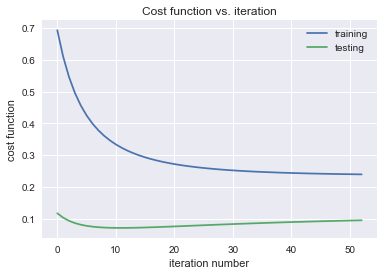

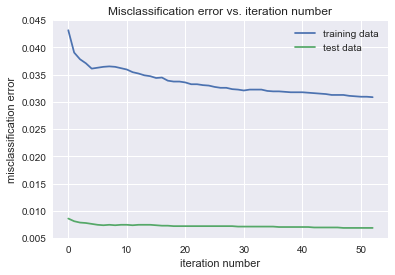

In [252]:
plt.figure()
plt.plot(k_vec,j_train_vec,label='training')
plt.plot(k_vec,j_test_vec,label='testing')
plt.xlabel('iteration number')
plt.ylabel('cost function')
plt.title('Cost function vs. iteration')
plt.legend()
index = np.argmin(j_train_vec)
k_best = k_vec[index]
w_best = w_vec[index]


plt.figure()
plt.plot(k_vec,train_classify_vec,label='training data')
plt.plot(k_vec,test_classify_vec,label='test data')
plt.xlabel('iteration number')
plt.ylabel('misclassification error')
plt.title('Misclassification error vs. iteration number')
plt.legend()
